In [122]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_f1_score
from sklearn_crfsuite.metrics import flat_classification_report
import nltk
from nltk.tag import pos_tag
import string
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/pavel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Загрузка данных

In [123]:
data = None
with open('data1.txt', 'r', encoding='utf8') as file:
    data = file.readlines()

In [124]:
del data[0]

In [125]:
def create_dict(data, drop_punct = False):    
    '''Returns dict with words and tags for furher creating DataFrame
    
    # Arguments
        data: list of strings (sentences)
        drop_punct: bool (drop punctuation or not)
        
    # Returns
        dict
    '''
    words = [] 
    tags = []
    sentences = []     # Добавим словам метки принадлежности к предложениям 
    num = 0
    for i, sent in enumerate(data):
        if sent != '\n':      # в исходном датасете предложения разделены пустой строкой
            s = sent.split()
            if drop_punct and all(x in string.punctuation for x in s[0]):  # проверка, 
                continue                                        # состоит ли строка полностью из знаков пунктуации
            words.append(s[0])
            tags.append(s[1])
            sentences.append(f'Sentence: {num}')
        else:        
            num += 1
            
    return {'Sentence #': sentences, 'Word':words, 'Tag':tags}

In [126]:
# Создаём Датафрейм для дальнейшего анализа данных
df = pd.DataFrame(create_dict(data))
df.head()

,Sentence #,Word,Tag
0,Sentence: 0,Man,O
1,Sentence: 0,i,O
2,Sentence: 0,hate,O
3,Sentence: 0,when,O
4,Sentence: 0,people,O


### Изучение данных

In [127]:
df.describe()

,Sentence #,Word,Tag
count,124629,124629,124629
unique,7243,28819,21
top,Sentence: 4654,.,O
freq,41,3495,115084


В нашем датасете 7423 предложения с 124629 токенами, самым частотным из которых является '.' - точка.

##### Распределение тэгов

In [128]:
df.groupby('Tag').count()

,Sentence #,Word
Tag,,
B-company,831,831
B-facility,395,395
B-geo-loc,1274,1274
B-movie,83,83
B-musicartist,287,287
B-other,941,941
B-person,1102,1102
B-product,380,380
B-sportsteam,268,268


##### Распределение тэгов (круговая диаграмма)

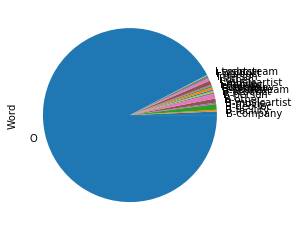

In [129]:
df.groupby('Tag').Word.count().plot.pie()

Тэг принадлежности к неименованной сущности ожидаемо гораздо более распространён

##### Распределение тэгов именованных сущностей

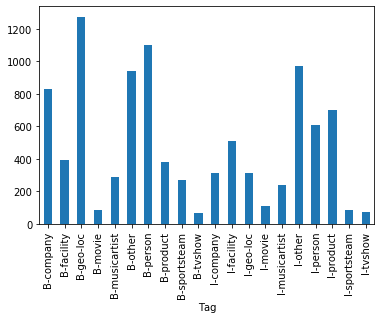

In [130]:
df[df.Tag != 'O'].groupby('Tag').Word.count().plot.bar()

##### Пунктуация

In [131]:
df[(df.Word == '.') & (df.Tag != 'O')].head() # точки, имеющие тэг именованной сущности (первые 5)

,Sentence #,Word,Tag
211,Sentence: 12,.,I-person
1243,Sentence: 72,.,I-facility
4854,Sentence: 287,.,I-sportsteam
9433,Sentence: 555,.,I-company
11352,Sentence: 656,.,I-person


Несмотря на то, что некоторые знаки пунктуации имеют тэг принадлежности к именованной сущности, на деле они ими не являются. Тем не менее, возможно, они несут некоторую дополнительную информацию для определения настоящих именованных сущностей. 
Попробуем обучить модель как на данных со знаками, так и без. 

In [132]:
# Создаём Датафрейм без знаков препинания (DataFrame Without Punctiation)
df_wp = pd.DataFrame(create_dict(data, drop_punct=True))
df_wp.head()

,Sentence #,Word,Tag
0,Sentence: 0,Man,O
1,Sentence: 0,i,O
2,Sentence: 0,hate,O
3,Sentence: 0,when,O
4,Sentence: 0,people,O


In [133]:
df_wp.describe()

,Sentence #,Word,Tag
count,108395,108395,108395
unique,7243,28626,21
top,Sentence: 2417,the,O
freq,36,2059,99000


### POS-тэги
Для задачи выделения именованных сущностей хорошим признаком является частеречная разметка. Её можно выполнить посредством библиотеки NLTK.

In [134]:
def create_pos_tags(data):
    '''Returns list of POS-tags
    
    # Arguments
        data: pandas.DataFrame, it must have columns 'Sentence #' and 'Word'
        
    # Returns
        list of strings
    '''
    agg = lambda s: [w for w in s['Word'].values.tolist()] # составляем предложения - список слов для каждого
    grouped = data.groupby("Sentence #").apply(agg)
    sentences = [s for s in grouped]    
    pos_tags = [nltk.pos_tag(sent) for sent in sentences]
    pos_tags = [tag[1] for pair in pos_tags for tag in pair]
   
    return pos_tags

In [135]:
pos_tags = create_pos_tags(df)
print(f'POS-тэги для первых пяти слов:\n{pos_tags[:5]}')

POS-тэги для первых пяти слов:
['NN', 'NN', 'VBP', 'WRB', 'NNS']


In [136]:
df.insert(2, 'POS', pos_tags)
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 0,Man,NN,O
1,Sentence: 0,i,NN,O
2,Sentence: 0,hate,VBP,O
3,Sentence: 0,when,WRB,O
4,Sentence: 0,people,NNS,O


### Создание признаков
Возьмем в качестве признаков часть тех, что описаны в данной статье https://arxiv.org/pdf/1709.04820.pdf, как "handcraft features". 
Среди них:
 - длина слова
 - POS-тэг
 - шаблоны капитализации
 - суффиксы и префиксы слов
 - метки первого и последнего слов в предложении
 - и другие
 
Кроме того, в списке признаков каждого слова будут присутствовать признаки его слов-соседей.

В вышеуказанной статье также присутствуют в качестве признаков эмбеддинги слов и предложений, но за неимением достаточных вычислительных мощностей и оперативной памяти, чтобы использовать предобученные векторы, в данной работе они не присутствуют.

Код частично взят из статьи https://www.depends-on-the-definition.com/named-entity-recognition-conditional-random-fields-python/

In [137]:
# Класс для получения предложений, представленных в виде списка кортежей со словом, pos-тэгом и тэгом в каждом
class sentence(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        self.empty = False
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]
        self.grouped = self.df.groupby("Sentence #").apply(agg)
        self.sentences = [s for s in self.grouped]

In [138]:
# для датафрейма с пуктуацией
getter = sentence(df)
sentences = getter.sentences
print(f'Каждое предложение имеет вид:\n{sentences[0]}')

Каждое предложение имеет вид:
[('Man', 'NN', 'O'), ('i', 'NN', 'O'), ('hate', 'VBP', 'O'), ('when', 'WRB', 'O'), ('people', 'NNS', 'O'), ('carry', 'VBP', 'O'), ('ragedy', 'JJ', 'O'), ('luggage', 'NN', 'O'), ('..', 'NNP', 'O'), ('ima', 'NN', 'O'), ('just', 'RB', 'O'), ('rip', 'VB', 'O'), ('it', 'PRP', 'O'), ('up', 'RP', 'O'), ('more', 'RBR', 'O'), ('with', 'IN', 'O'), ('the', 'DT', 'O'), ('belt', 'NN', 'O'), ('loader', 'NN', 'O'), ('#itaintmines', 'NNS', 'O')]


In [139]:
# функция генерация признаков
def word2features(sent, i):
    ''' Returns dict of features
    
    # Arguments
        sent: tuple(word, pos, tag)
        i: int, index of tuple in list
        
    # Returns
        dict
    '''
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[:3]': word[:3],
        'word[:2]': word[:2],             # префикс
        'word[-3:]': word[-3:],           # суффикс
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(), # капитализация
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True    # Первое слово в предложении

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True  # Последнее слово в предложении

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

In [140]:
# для датафрейма с пунктуацией 
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

### Обучение модели

В качестве алгоритма классификации были опробованы Perceptron, SGDClassifier, CRF (метод условных случайных полей).
Последний показал наилучшие результаты.
Использование нейронных сетей и языковых моделей, как, например, здесь: https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/ - невозможно ввиду ограниченных вычислительных ресурсов (а также малой обучающей выборки).
Ниже приведен код для обучения CRF-классификатора и оценки его предсказаний.

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=43) 

In [148]:
crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [149]:
print(flat_classification_report(y_pred=crf.predict(X_test), y_true=y_test))

               precision    recall  f1-score   support

    B-company       0.79      0.53      0.63       156
   B-facility       0.78      0.53      0.63        87
    B-geo-loc       0.83      0.53      0.64       258
      B-movie       0.80      0.18      0.30        22
B-musicartist       0.40      0.15      0.22        54
      B-other       0.69      0.40      0.50       179
     B-person       0.68      0.42      0.52       225
    B-product       0.52      0.20      0.29        71
 B-sportsteam       0.50      0.22      0.31        50
     B-tvshow       1.00      0.06      0.11        17
    I-company       0.60      0.48      0.53        73
   I-facility       0.80      0.62      0.70       117
    I-geo-loc       0.85      0.42      0.56        69
      I-movie       1.00      0.24      0.39        29
I-musicartist       0.27      0.06      0.10        62
      I-other       0.56      0.43      0.49       169
     I-person       0.63      0.52      0.57       124
    I-pro

Из-за присутствия дисбаланса в классах (представителей класса 'O' гораздо больше остальных) результаты получаются завышенными. 


Исключим данный тэг из нашего набора классов и посмотрим на более правдивый отчет.

In [25]:
new_classes = df.Tag.unique().tolist()
new_classes.pop(0)
new_classes

['B-sportsteam',
 'I-sportsteam',
 'B-facility',
 'I-facility',
 'B-company',
 'B-geo-loc',
 'B-other',
 'I-other',
 'B-person',
 'I-person',
 'B-movie',
 'I-movie',
 'B-product',
 'I-product',
 'I-geo-loc',
 'B-musicartist',
 'I-musicartist',
 'B-tvshow',
 'I-company',
 'I-tvshow']

In [150]:
print(flat_classification_report(y_pred=crf.predict(X_test), y_true=y_test, labels=new_classes))

               precision    recall  f1-score   support

 B-sportsteam       0.50      0.22      0.31        50
 I-sportsteam       0.50      0.20      0.29        15
   B-facility       0.78      0.53      0.63        87
   I-facility       0.80      0.62      0.70       117
    B-company       0.79      0.53      0.63       156
    B-geo-loc       0.83      0.53      0.64       258
      B-other       0.69      0.40      0.50       179
      I-other       0.56      0.43      0.49       169
     B-person       0.68      0.42      0.52       225
     I-person       0.63      0.52      0.57       124
      B-movie       0.80      0.18      0.30        22
      I-movie       1.00      0.24      0.39        29
    B-product       0.52      0.20      0.29        71
    I-product       0.31      0.29      0.30       139
    I-geo-loc       0.85      0.42      0.56        69
B-musicartist       0.40      0.15      0.22        54
I-musicartist       0.27      0.06      0.10        62
     B-tv

Стоит обратить внимание на класс I-tvshow, оценки качества классификации которого равны нулю. Это самый малочисленный класс, поэтому либо классификатору не хватило данных, чтобы обучиться его классифицировать, либо объекты с данным тэгом вовсе не попали в обучающую выборку.

#### Датафрейм без пунктуации
Проверим, как исключение пунктуации повлияет на работу алгоритма.

In [152]:
# df_wp.insert(2, 'POS', create_pos_tags(df_wp)) # для данных без пунктуации
getter = sentence(df_wp)
sentences = getter.sentences

X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=43) 

crf = CRF(algorithm = 'lbfgs',
         c1 = 0.1,
         c2 = 0.1,
         max_iterations = 100,
         all_possible_transitions = False)

crf.fit(X_train, y_train)

print(flat_classification_report(y_pred=crf.predict(X_test), y_true=y_test, labels=new_classes))

               precision    recall  f1-score   support

 B-sportsteam       0.47      0.18      0.26        50
 I-sportsteam       0.29      0.14      0.19        14
   B-facility       0.78      0.52      0.62        87
   I-facility       0.78      0.59      0.67       116
    B-company       0.83      0.53      0.65       156
    B-geo-loc       0.79      0.52      0.62       258
      B-other       0.68      0.39      0.50       179
      I-other       0.53      0.39      0.45       162
     B-person       0.70      0.42      0.53       225
     I-person       0.68      0.56      0.61       120
      B-movie       1.00      0.09      0.17        22
      I-movie       1.00      0.21      0.34        29
    B-product       0.73      0.23      0.34        71
    I-product       0.46      0.23      0.31       128
    I-geo-loc       0.68      0.42      0.51        65
B-musicartist       0.73      0.15      0.25        54
I-musicartist       0.67      0.07      0.13        55
     B-tv

Для классификации некоторых классов (например, B-person и I-person) результаты для данного датасета получились выше, в то время как для других классов - ниже. В целом - что на датасете без пунктуацией, что с ней - результаты классификации оказались приблизительно равными. 

Ниже можно ознакомиться с результатами работы алгоритма

In [162]:
for k, i, j in zip(X_test, crf.predict(X_test), y_test):
    #print(i, end='\n\n')
    for w, a, b in zip(k, i, j):
        print(f'{w["word.lower()"]}: Predict: {a}, True: {b}')

after: Predict: O, True: O
the: Predict: O, True: O
san: Predict: B-geo-loc, True: B-geo-loc
bernardino: Predict: I-geo-loc, True: I-geo-loc
shooting: Predict: O, True: O
three: Predict: O, True: O
approaches: Predict: O, True: O
to: Predict: O, True: O
gun: Predict: O, True: O
violence: Predict: O, True: O
http://www.newyorker.com/news/news-desk/after-the-san-bernardino-shooting-three-approaches-to-gun-violence: Predict: O, True: O
…: Predict: O, True: O
via: Predict: O, True: O
@joshuarothman: Predict: O, True: O
rt: Predict: O, True: O
@cochraneeagle: Predict: O, True: O
your: Predict: O, True: O
#cochrane: Predict: B-sportsteam, True: B-product
eagle: Predict: I-sportsteam, True: I-product
front: Predict: O, True: O
for: Predict: O, True: O
april: Predict: O, True: O
23: Predict: O, True: O
2015: Predict: O, True: O
http://t.co/ptnmefjhc3: Predict: O, True: O
apple: Predict: B-product, True: B-product
ipod: Predict: I-product, True: I-product
touch: Predict: I-product, True: I-prod

3: Predict: O, True: O
killed: Predict: O, True: O
2: Predict: O, True: O
wounded: Predict: O, True: O
in: Predict: O, True: O
shooting: Predict: O, True: O
outside: Predict: O, True: O
irvington: Predict: B-geo-loc, True: B-geo-loc
nj: Predict: B-geo-loc, True: B-geo-loc
nightclub: Predict: O, True: O
authorities: Predict: O, True: O
say: Predict: O, True: O
no: Predict: O, True: O
arrests: Predict: O, True: O
@nbcnewyork: Predict: O, True: O
3: Predict: O, True: O
http://bit.ly/1g0xz7b: Predict: O, True: O
final: Predict: O, True: O
grades: Predict: O, True: O
go: Predict: O, True: O
up: Predict: O, True: O
tomorrow: Predict: O, True: O
@marco_p_shite: Predict: O, True: O
never: Predict: O, True: O
eat: Predict: O, True: O
out: Predict: O, True: O
on: Predict: O, True: O
a: Predict: O, True: O
monday: Predict: O, True: O
#shady: Predict: O, True: O
you: Predict: O, True: O
may: Predict: O, True: O
be: Predict: O, True: O
offered: Predict: O, True: O
an: Predict: O, True: O
opportunit

&amp;: Predict: O, True: O
#bigben: Predict: O, True: B-musicartist
live: Predict: O, True: O
this: Predict: O, True: O
friday: Predict: O, True: O
at: Predict: O, True: O
#clublacura: Predict: B-facility, True: B-facility
http://t.co/ticd9uibsq: Predict: O, True: O
6: Predict: O, True: O
at: Predict: O, True: O
least: Predict: O, True: O
two: Predict: O, True: O
dead: Predict: O, True: O
seven: Predict: O, True: O
wounded: Predict: O, True: O
in: Predict: O, True: O
detroit: Predict: B-geo-loc, True: B-geo-loc
shooting: Predict: O, True: O
police: Predict: O, True: O
at: Predict: O, True: O
least: Predict: O, True: O
two: Predict: O, True: O
people: Predict: O, True: O
were: Predict: O, True: O
shot: Predict: O, True: O
dead: Predict: O, True: O
and: Predict: O, True: O
seven: Predict: O, True: O
oth: Predict: O, True: O
http://yhoo.it/17cw2eb: Predict: O, True: O
'rt: Predict: O, True: O
@veganbotanicals: Predict: O, True: O
alright: Predict: O, True: O
#vegans: Predict: O, True: O
a

laugh: Predict: O, True: O
saying: Predict: O, True: O
i: Predict: O, True: O
just: Predict: O, True: O
want: Predict: O, True: O
what: Predict: O, True: O
i: Predict: O, True: O
can't: Predict: O, True: O
have: Predict: O, True: O
won't: Predict: O, True: O
even: Predict: O, True: O
give: Predict: O, True: O
me: Predict: O, True: O
a: Predict: O, True: O
chance: Predict: O, True: O
le: Predict: O, True: O
menu: Predict: O, True: O
brunch: Predict: O, True: O
de: Predict: O, True: O
ce: Predict: O, True: O
samedi: Predict: O, True: O
28: Predict: O, True: O
nov: Predict: O, True: O
yummy: Predict: O, True: O
https://t.co/dsx1epuyr5: Predict: O, True: O
why: Predict: O, True: O
doesn't: Predict: O, True: O
my: Predict: O, True: O
vehicle: Predict: O, True: O
have: Predict: O, True: O
a: Predict: O, True: O
spare: Predict: O, True: O
tire: Predict: O, True: O
your: Predict: O, True: O
car: Predict: O, True: O
may: Predict: O, True: O
be: Predict: O, True: O
equipped: Predict: O, True: O


navy: Predict: I-facility, True: I-facility
yard: Predict: I-facility, True: I-facility
at: Predict: O, True: O
least: Predict: O, True: O
12: Predict: O, True: O
people: Predict: O, True: O
are: Predict: O, True: O
killed: Predict: O, True: O
and: Predict: O, True: O
four: Predict: O, True: O
others: Predict: O, True: O
injured: Predict: O, True: O
in: Predict: O, True: O
http://www.bbc.co.uk/news/world-us-canada-24111481#sa-ns_mchannel=rss&ns_source=publicrss20-sa: Predict: O, True: O
…: Predict: O, True: O
@lastmanfox: Predict: O, True: O
he: Predict: O, True: O
just: Predict: O, True: O
sat: Predict: O, True: O
on: Predict: O, True: O
carol: Predict: B-geo-loc, True: B-person
's: Predict: O, True: O
tomatoes: Predict: O, True: O
livestrong: Predict: O, True: B-other
day: Predict: O, True: I-other
is: Predict: O, True: O
10-02-10: Predict: O, True: O
around: Predict: O, True: O
the: Predict: O, True: O
world: Predict: O, True: O
been: Predict: O, True: O
working: Predict: O, True: O

sis: Predict: O, True: O
abby: Predict: O, True: B-person
tonite: Predict: O, True: O
ipod: Predict: O, True: B-product
touch: Predict: O, True: I-product
2nd: Predict: O, True: I-product
generation: Predict: O, True: I-product
8gb: Predict: O, True: I-product
full: Predict: O, True: O
read: Predict: O, True: O
by: Predict: O, True: O
ebay: Predict: O, True: B-company
http://t.co/hfwdhq4pfe: Predict: O, True: O
http://t.co/bibhqsi6ee: Predict: O, True: O
also: Predict: O, True: O
i: Predict: O, True: O
learned: Predict: O, True: O
at: Predict: O, True: O
school: Predict: O, True: O
today: Predict: O, True: O
that: Predict: O, True: O
everyone: Predict: O, True: O
in: Predict: O, True: O
fact: Predict: O, True: O
knows: Predict: O, True: O
@penguin1124: Predict: O, True: O
i: Predict: O, True: O
learned: Predict: O, True: O
this: Predict: O, True: O
no: Predict: O, True: O
joke: Predict: O, True: O
during: Predict: O, True: O
choir: Predict: O, True: O
#fact: Predict: O, True: O
apparen